## Part 6a - Machine learning for volatility prediction

### In this section, we will apply conventional machine learning algorithms to model volatility.

### We begin our modeling exercise using a naive approach, where we assume the input parameters by themselves are good predictors of volatility.

### We then add complexity in order to achieve a better fit.

In [1]:
import numpy as np, pandas as pd
from datetime import datetime, timedelta
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import bisect
from scipy import stats
import seaborn as sns
from sklearn import linear_model
from sklearn import tree

### 1) Open the pickle files from the previous modules.

In [2]:
with open('./returns.pkl', 'rb') as f:
  returns = pickle.load(f)
  f.close()
with open('./turb_model_perf_stats.pkl', 'rb') as f:
  turb_model_perf_stats = pickle.load(f)
  f.close()
with open('./turb_model_weights.pkl', 'rb') as f:
  turb_model_weights = pickle.load(f)
  f.close()
with open('./dxy.pkl', 'rb') as f:
  dxy = pickle.load(f)
  f.close()
with open('./dxy_forward_sq.pkl', 'rb') as f:
  dxy_forward_sq = pickle.load(f)
  f.close()

### 2) Preview data to confirm everything is consistent with results from previous modules

In [3]:
print(returns.head())

                 AUD       CAD       CHF       EUR       GBP       JPY  \
1975-01-02 -0.002129 -0.001712 -0.009915 -0.003544 -0.005745 -0.001502   
1975-01-03 -0.000947  0.000015  0.008500  0.007886  0.003424  0.002711   
1975-01-06 -0.001158  0.000668 -0.001023  0.008174  0.002346 -0.004728   
1975-01-07  0.004193 -0.001726  0.001702  0.002150  0.001702  0.002410   
1975-01-08 -0.001489 -0.000200 -0.015237 -0.008650 -0.001997  0.000122   

                 NOK       NZD       SEK  
1975-01-02 -0.003299  0.000536 -0.004704  
1975-01-03  0.008801 -0.001924  0.007113  
1975-01-06  0.002759 -0.001129  0.009237  
1975-01-07  0.005434  0.004567 -0.001466  
1975-01-08 -0.006315 -0.000034 -0.006188  


In [4]:
print(turb_model_perf_stats.head(10))

                     insample rmse insample excess rmse out-of-sample rmse  \
lookbacks smoothings                                                         
65        1             0.00327657         -5.48214e-05           0.003141   
          5             0.00314802         -0.000184387         0.00312619   
          10            0.00318987         -0.000143484         0.00317671   
          20            0.00316473         -0.000171045         0.00321694   
          40            0.00320098         -0.000140053         0.00320426   
130       1             0.00326596         -7.85186e-05         0.00304906   
          5             0.00314005          -0.00020514         0.00300011   
          10            0.00318002         -0.000166609         0.00303926   
          20             0.0031926          -0.00015542         0.00308299   
          40            0.00325105         -0.000102043         0.00308918   

                     out-of-sample excess rmse estimation rmse 

In [5]:
print(turb_model_weights.dropna().head())

lookbacks        65                                                130  \
smoothings        1         5         10        20        40        1    
1977-02-22  0.902193  0.960381  0.652799  0.866186  0.753031  0.827634   
1977-02-23  0.957112  0.969314  0.715591  0.887417  0.789597  0.909198   
1977-02-24  0.132156  0.743057  0.540824  0.798403  0.761048  0.173153   
1977-02-25  0.209975  0.503787  0.416019  0.765875  0.719398  0.192020   
1977-02-28  0.178149  0.384346  0.609253  0.774250  0.646461  0.115763   

lookbacks                                             ...          390  \
smoothings        5         10        20        40    ...           1    
1977-02-22  0.928993  0.710573  0.906490  0.849277    ...     0.869097   
1977-02-23  0.938041  0.727505  0.908463  0.867697    ...     0.920257   
1977-02-24  0.701023  0.588305  0.860525  0.831056    ...     0.228252   
1977-02-25  0.493116  0.471746  0.809627  0.799366    ...     0.183099   
1977-02-28  0.324941  0.522544  0.773

In [6]:
dxy.columns = ['DXY']
print(dxy.head())

                 DXY
1975-01-02 -0.002635
1975-01-03  0.002982
1975-01-06 -0.001521
1975-01-07  0.001342
1975-01-08 -0.001337


In [7]:
dxy_forward_sq.columns = ['DXY_forward']
print(dxy_forward_sq.head())

             DXY_forward
1975-01-02  8.893707e-06
1975-01-03  2.313472e-06
1975-01-06  1.800401e-06
1975-01-07  1.786578e-06
1975-01-08  3.895592e-07


### 3) "Naive" modeling - regression
#### We use the parameters and attempt to build a model

In [19]:
framework_params = {'insample_start_date': '1975-01-02',
                    'insample_end_date': '1994-12-31',
                    'estimationsample_start_date': '1995-01-01',
                    'estimationsample_end_date': '2004-12-31',
                    'outofsample_start_date': '2005-01-01',
                    'outofsample_end_date': '2017-12-26',
                    'verbose': False}

X = returns.loc[framework_params['insample_start_date']:framework_params['insample_end_date']].dropna()
y = dxy.loc[X.index]
reg_naive = linear_model.LinearRegression(fit_intercept=False).fit(X, y)

In [22]:
print(reg_naive.score(X, y))

1.0


In [23]:
print(reg_naive.coef_)

[[-1.13094303e-16  1.19000000e-01  3.60000000e-02 -3.70168731e-16
   1.36000000e-01  5.76000000e-01 -7.46824047e-17  1.12206929e-17
   9.10000000e-02]]


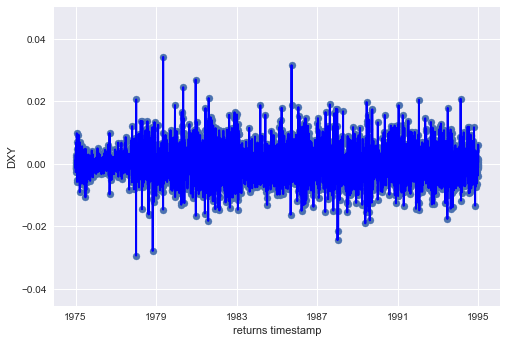

In [24]:
#We plot the resulting regression line
plt.scatter(X.index, y)
plt.plot(X.index, reg_naive.predict(X), color='blue', linewidth=2)
plt.xlabel('returns timestamp')
plt.ylabel('DXY')
plt.show()

In [ ]:
#We confirm orediction power
plt.scatter(X.index, y)
plt.plot(X.index, reg_naive.predict(X), color='blue', linewidth=2)
plt.xlabel('returns timestamp')
plt.ylabel('DXY')
plt.show()

In [268]:
best_turb_model = turb_model_perf_stats['out-of-sample excess rmse'].astype(float).idxmin(axis=0)
best_turb_model

(390, 5)

In [298]:
best_model_weights = turb_model_weights.loc[:,best_turb_model]
other_model_weights = turb_model_weights.drop(columns=best_turb_model)
other_model_weights.tail(10)

lookbacks        65                                                130  \
smoothings        1         5         10        20        40        1    
2017-12-13  0.523190  0.436978  0.334565  0.512466  0.475362  0.423742   
2017-12-14  0.199690  0.298505  0.383942  0.492209  0.517990  0.233294   
2017-12-15  0.556763  0.308992  0.503110  0.507012  0.533242  0.426887   
2017-12-18  0.262371  0.313070  0.407854  0.450331  0.494916  0.303656   
2017-12-19  0.807297  0.480287  0.426905  0.462992  0.506648  0.845519   
2017-12-20  0.296332  0.405904  0.440902  0.448968  0.543801  0.350629   
2017-12-21  0.297108  0.453680  0.373445  0.435333  0.549863  0.305621   
2017-12-22  0.560644  0.454846  0.383942  0.430269  0.571373  0.439662   
2017-12-25  0.995343  0.723441  0.520801  0.473120  0.585452  0.995283   
2017-12-26  0.878129  0.743445  0.658631  0.497663  0.598162  0.920008   

lookbacks                                             ...          260  \
smoothings        5         10        20        40    ...           40   
2017-12-13  0.385523  0.350856  0.477214  0.451575    ...     0.384428   
2017-12-14  0.310582  0.385509  0.471296  0.491979    ...     0.425493   
2017-12-15  0.276751  0.447332  0.486092  0.502872    ...     0.433015   
2017-12-18  0.328482  0.387872  0.450582  0.481481    ...     0.413092   
2017-12-19  0.473249  0.404213  0.465772  0.496732    ...     0.430169   
2017-12-20  0.455350  0.443591  0.455317  0.532581    ...     0.457410   
2017-12-21  0.489575  0.408742  0.438153  0.538721    ...     0.457003   
2017-12-22  0.493509  0.387675  0.432235  0.551000    ...     0.464932   
2017-12-25  0.699646  0.519984  0.457289  0.561695    ...     0.473674   
2017-12-26  0.721873  0.637527  0.487670  0.576352    ...     0.485871   

lookbacks        390                                     520            \
smoothings        1         10        20        40        1         5    
2017-12-13  0.435377  0.294667  0.451029  0.466277  0.447850  0.345974   
2017-12-14  0.193455  0.329944  0.451237  0.522865  0.223074  0.282914   
2017-12-15  0.370961  0.370409  0.456852  0.530173  0.356748  0.235194   
2017-12-18  0.286040  0.328076  0.432314  0.512007  0.292891  0.291223   
2017-12-19  0.874275  0.337829  0.449574  0.527668  0.859940  0.463357   
2017-12-20  0.266984  0.373521  0.430859  0.544373  0.265432  0.405198   
2017-12-21  0.227423  0.337207  0.413184  0.535811  0.304172  0.440562   
2017-12-22  0.228045  0.291554  0.400083  0.543120  0.230736  0.395824   
2017-12-25  0.997929  0.396555  0.409233  0.554395  0.997233  0.549638   
2017-12-26  0.829950  0.509234  0.419838  0.560033  0.845040  0.546868   

lookbacks                                 
smoothings        10        20        40  
2017-12-13  0.336532  0.514854  0.541747  
2017-12-14  0.378759  0.515281  0.584460  
2017-12-15  0.409682  0.510579  0.588968  
2017-12-18  0.362977  0.471041  0.573514  
2017-12-19  0.368949  0.491558  0.585963  
2017-12-20  0.403924  0.460782  0.596480  
2017-12-21  0.374707  0.445608  0.595407  
2017-12-22  0.316272  0.425305  0.600129  
2017-12-25  0.426957  0.439410  0.609573  
2017-12-26  0.534869  0.452233  0.616227  

[10 rows x 24 columns]

In [299]:
best_model_vol = (1-best_model_weights).multiply(dxy_forward_sq[dxy_forward_sq.columns[0]])


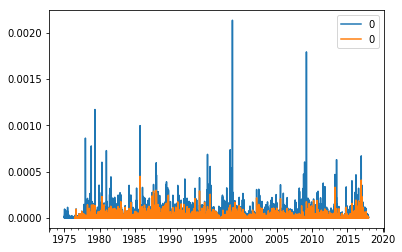

In [300]:
dxy_excess = dxy_forward_sq[0]-best_model_vol
pd.concat([dxy_forward_sq[0],dxy_excess],axis=1).plot()

In [301]:
dxy_excess.mean()

9.041396742928302e-06

In [302]:
weights_excess = other_model_weights.subtract(best_model_weights,axis='index')

In [303]:
weights_excess.tail(10)

lookbacks        65                                                130  \
smoothings        1         5         10        20        40        1    
2017-12-13  0.196698  0.110486  0.008072  0.185973  0.148869  0.097250   
2017-12-14 -0.057773  0.041042  0.126480  0.234746  0.260527 -0.024169   
2017-12-15  0.335785  0.088014  0.282132  0.286034  0.312264  0.205908   
2017-12-18 -0.014370  0.036329  0.131113  0.173590  0.218175  0.026914   
2017-12-19  0.367206  0.040196 -0.013186  0.022901  0.066557  0.405428   
2017-12-20 -0.101263  0.008309  0.043307  0.051372  0.146206 -0.046966   
2017-12-21 -0.116449  0.040123 -0.040112  0.021776  0.136306 -0.107936   
2017-12-22  0.195802  0.090003  0.019100  0.065426  0.206530  0.074819   
2017-12-25  0.479381  0.207480  0.004839 -0.042841  0.069490  0.479321   
2017-12-26  0.369215  0.234532  0.149718 -0.011251  0.089248  0.411094   

lookbacks                                             ...          260  \
smoothings        5         10        20        40    ...           40   
2017-12-13  0.059031  0.024364  0.150722  0.125082    ...     0.057935   
2017-12-14  0.053120  0.128046  0.213833  0.234516    ...     0.168030   
2017-12-15  0.055772  0.226354  0.265113  0.281893    ...     0.212036   
2017-12-18  0.051740  0.111130  0.173841  0.204740    ...     0.136351   
2017-12-19  0.033158 -0.035878  0.025681  0.056641    ...    -0.009922   
2017-12-20  0.057755  0.045996  0.057721  0.134985    ...     0.059815   
2017-12-21  0.076018 -0.004815  0.024596  0.125163    ...     0.043446   
2017-12-22  0.128667  0.022832  0.067393  0.186158    ...     0.100089   
2017-12-25  0.183684  0.004022 -0.058672  0.045734    ...    -0.042288   
2017-12-26  0.212959  0.128613 -0.021244  0.067438    ...    -0.023043   

lookbacks        390                                     520            \
smoothings        1         10        20        40        1         5    
2017-12-13  0.108884 -0.031826  0.124537  0.139784  0.121358  0.019481   
2017-12-14 -0.064008  0.072481  0.193775  0.265402 -0.034389  0.025452   
2017-12-15  0.149983  0.149430  0.235873  0.309195  0.135769  0.014215   
2017-12-18  0.009298  0.051335  0.155573  0.235265  0.016149  0.014482   
2017-12-19  0.434184 -0.102262  0.009483  0.087576  0.419849  0.023266   
2017-12-20 -0.130611 -0.024074  0.033263  0.146777 -0.132163  0.007603   
2017-12-21 -0.186134 -0.076350 -0.000374  0.122254 -0.109385  0.027005   
2017-12-22 -0.136798 -0.073288  0.035241  0.178277 -0.134106  0.030982   
2017-12-25  0.481967 -0.119407 -0.106729  0.038434  0.481271  0.033676   
2017-12-26  0.321037  0.000321 -0.089076  0.051120  0.336127  0.037955   

lookbacks                                 
smoothings        10        20        40  
2017-12-13  0.010040  0.188361  0.215255  
2017-12-14  0.121296  0.257818  0.326997  
2017-12-15  0.188704  0.289601  0.367989  
2017-12-18  0.086236  0.194300  0.296772  
2017-12-19 -0.071143  0.051467  0.145871  
2017-12-20  0.006329  0.063187  0.198885  
2017-12-21 -0.038850  0.032051  0.181850  
2017-12-22 -0.048570  0.060462  0.235286  
2017-12-25 -0.089005 -0.076552  0.093611  
2017-12-26  0.025955 -0.056680  0.107313  

[10 rows x 24 columns]

In [304]:
vol_excess = weights_excess.multiply(-dxy_forward_sq[0],axis=0)
vol_excess.tail(10)

lookbacks            65                                             \
smoothings            1             5             10            20   
2017-12-13 -1.847478e-06 -1.037732e-06 -7.581604e-08 -1.746749e-06   
2017-12-14  1.886183e-07 -1.339938e-07 -4.129320e-07 -7.664007e-07   
2017-12-15 -3.081213e-06 -8.076268e-07 -2.588888e-06 -2.624690e-06   
2017-12-18  2.605896e-07 -6.588103e-07 -2.377654e-06 -3.147957e-06   
2017-12-19 -1.686404e-08 -1.846026e-09  6.055754e-10 -1.051719e-09   
2017-12-20  8.860815e-08 -7.270354e-09 -3.789458e-08 -4.495225e-08   
2017-12-21  1.190332e-07 -4.101359e-08  4.100266e-08 -2.225915e-08   
2017-12-22 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00   
2017-12-25 -8.071184e-07 -3.493270e-07 -8.147403e-09  7.213088e-08   
2017-12-26           NaN           NaN           NaN           NaN   

lookbacks                          130                              \
smoothings            40            1             5             10   
2017-12-13 -1.398249e-06 -9.134138e-07 -5.544437e-07 -2.288374e-07   
2017-12-14 -8.505708e-07  7.890601e-08 -1.734250e-07 -4.180463e-07   
2017-12-15 -2.865381e-06 -1.889448e-06 -5.117742e-07 -2.077058e-06   
2017-12-18 -3.956478e-06 -4.880773e-07 -9.382806e-07 -2.015288e-06   
2017-12-19 -3.056664e-09 -1.861941e-08 -1.522802e-09  1.647700e-09   
2017-12-20 -1.279344e-07  4.109697e-08 -5.053708e-08 -4.024774e-08   
2017-12-21 -1.393310e-07  1.103316e-07 -7.770504e-08  4.922205e-09   
2017-12-22 -0.000000e+00 -0.000000e+00 -0.000000e+00 -0.000000e+00   
2017-12-25 -1.169979e-07 -8.070182e-07 -3.092632e-07 -6.772376e-09   
2017-12-26           NaN           NaN           NaN           NaN   

lookbacks                                   ...                260  \
smoothings            20            40      ...                 40   
2017-12-13 -1.415651e-06 -1.174829e-06      ...      -5.441545e-07   
2017-12-14 -6.981248e-07 -7.656492e-07      ...      -5.485865e-07   
2017-12-15 -2.432724e-06 -2.586699e-06      ...      -1.945680e-06   
2017-12-18 -3.152506e-06 -3.712851e-06      ...      -2.472647e-06   
2017-12-19 -1.179415e-09 -2.601250e-09      ...       4.556933e-10   
2017-12-20 -5.050778e-08 -1.181161e-07      ...      -5.233957e-08   
2017-12-21 -2.514215e-08 -1.279412e-07      ...      -4.441047e-08   
2017-12-22 -0.000000e+00 -0.000000e+00      ...      -0.000000e+00   
2017-12-25  9.878500e-08 -7.700013e-08      ...       7.119958e-08   
2017-12-26           NaN           NaN      ...                NaN   

lookbacks            390                                            \
smoothings            1             10            20            40   
2017-12-13 -1.022694e-06  2.989209e-07 -1.169708e-06 -1.312920e-06   
2017-12-14  2.089732e-07 -2.366374e-07 -6.326366e-07 -8.664870e-07   
2017-12-15 -1.376265e-06 -1.371197e-06 -2.164411e-06 -2.837222e-06   
2017-12-18 -1.686228e-07 -9.309335e-07 -2.821234e-06 -4.266409e-06   
2017-12-19 -1.994005e-08  4.696409e-09 -4.354875e-10 -4.021976e-09   
2017-12-20  1.142885e-07  2.106534e-08 -2.910648e-08 -1.284342e-07   
2017-12-21  1.902648e-07  7.804482e-08  3.818914e-10 -1.249673e-07   
2017-12-22  0.000000e+00  0.000000e+00 -0.000000e+00 -0.000000e+00   
2017-12-25 -8.114728e-07  2.010411e-07  1.796966e-07 -6.470952e-08   
2017-12-26           NaN           NaN           NaN           NaN   

lookbacks            520                                            \
smoothings            1             5             10            20   
2017-12-13 -1.139848e-06 -1.829751e-07 -9.429824e-08 -1.769175e-06   
2017-12-14  1.122736e-07 -8.309479e-08 -3.960084e-07 -8.417271e-07   
2017-12-15 -1.245839e-06 -1.304430e-07 -1.731576e-06 -2.657423e-06   
2017-12-18 -2.928587e-07 -2.626149e-07 -1.563841e-06 -3.523516e-06   
2017-12-19 -1.928172e-08 -1.068512e-09  3.267250e-09 -2.363632e-09   
2017-12-20  1.156467e-07 -6.652641e-09 -5.537813e-09 -5.529032e-08   
2017-12-21  1.118129e-07 -2.760455e-08  3.971269e-08 -3.276215e-08   
2017-1

In [305]:
framework_params = {'insample_start_date': '1975-01-02',
                    'insample_end_date': '1994-12-31',
                    'estimationsample_start_date': '1995-01-01',
                    'estimationsample_end_date': '2004-12-31',
                    'outofsample_start_date': '2005-01-01',
                    'outofsample_end_date': '2017-12-26',
                    'verbose': False}

X = vol_excess.loc[framework_params['insample_start_date']:framework_params['insample_end_date']].dropna()
y = dxy_excess.loc[X.index]

reg = linear_model.LinearRegression(fit_intercept=False).fit(X, y)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in minimum
  if __name__ == '__main__':
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in maximum
  if __name__ == '__main__':


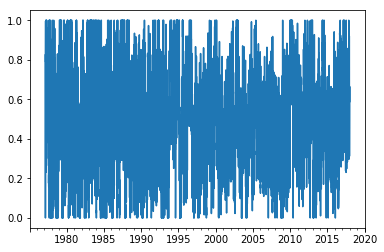

In [318]:
np.maximum(np.minimum(weights_excess.dot(reg.coef_).add(best_model_weights),1),0).plot()

In [288]:
vol_excess.columns[15]

(390, 5)